This Jupyter notebook predicts the effect on traffic generation of transforing office built up area in housing and other land uses in selected areas using a two part Hurdle model with gradient boosting.

# imports

In [25]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_regression
import math

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

import statsmodels.api as sm

import scipy.stats as stats

from sklearn.feature_selection import RFE
import spreg
# import cudf

import seaborn as sns

import swifter
from scipy.stats import yeojohnson
import warnings
warnings.filterwarnings("ignore")

import sys
from io import StringIO

# Temporarily redirect stdout
old_stdout = sys.stdout


In [26]:
import xgboost
xgboost.__version__

'2.0.3'

## Pickle for results saving

In [27]:
# Pickle a file and then compress it into a file with extension 
import bz2
import pickle
import _pickle as cPickle

def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)
    
# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file + '.pbz2', 'rb')
    # data = cPickle.load(data)

    data = pd.compat.pickle_compat.load(data) # for pandas >2.0?
    
    return data

In [28]:
from matplotlib.font_manager import FontProperties

# !!! change it to your path
personal_path = '/cluster/home/jaargota/Fonts/'

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt


# Find the custom font
custom_fonts = fm.findSystemFonts(fontpaths=personal_path, fontext='ttf')

# Add the custom fonts to Matplotlib
for font in custom_fonts:
    fm.fontManager.addfont(font)

# Print the names of custom fonts to verify
for font in custom_fonts:
    print(fm.FontProperties(fname=font).get_name())

# Update the font cache (this will refresh the Matplotlib font list)
plt.rcParams.update({'font.family': 'sans-serif'})

Helvetica
Helvetica Compressed
Helvetica Light
Helvetica
Helvetica
Helvetica


In [29]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

In [30]:
# matplotlib.font_manager.findSystemFonts(fontpaths=personal_path, fontext='ttf')
# plt.rcParams['font.family']=[font_path]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Helvetica"]

# Load data

## Mobility OD data

In [31]:
# all_data = decompress_pickle("../../01-data/OD_vect_on_origin_data_v21wq_selected_cols")
all_data = decompress_pickle("../../01-data/OD_vect_on_origin_data_v26wq_selected_cols")

## From consolidating data. Rebuild zone data with variations/interventions

## load land use features for TAZs

In [32]:
# load data
gdf_RMB_total_with_features = decompress_pickle("../../01-data/CZT_zones_EMO96_ALL_DATA_catastro_INE_OSM_GHSL_173cols_sorted_03.pkl") #expanded cadaster and OSM data
gdf_RMB_total_with_features = gdf_RMB_total_with_features.to_crs("esri:54009")

Classify columns

In [33]:
target_columns = ['total_generated_sum', 'total_generated_entropy', 'leaving_sum',  'leaving_entropy','arriving_sum','arriving_entropy', 'internal', 'ratio_internal', 'ratio_arriving_leaving', 'opening_index']

EMO_96_cols = ['OBJECTID', 'CNT_CZT', 'SUM_POBLAC', 'LTL', 'ESTUDIANTS', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry']

cadastre_cols = [
    'superficie_construida_x|sum|V','superficie_construida_x|mean|V', 'superficie_construida_x|std|V', 'superficie_construida_x|entropy|V',
    'año_antiguedad|mean|V', 'año_antiguedad|count|V', 'count/km2|V','superficie_m2/km2|V', 
    'superficie_construida_x|sum|C','superficie_construida_x|sum|O', 'superficie_construida_x|mean|C','superficie_construida_x|mean|O', 'superficie_construida_x|std|C','superficie_construida_x|std|O', 
    'superficie_construida_x|entropy|C','superficie_construida_x|entropy|O',
    'año_antiguedad|mean|C','año_antiguedad|mean|O', 'año_antiguedad|count|C','año_antiguedad|count|O', 'count/km2|O', 'count/km2|C',
    'superficie_m2/km2|O', 'superficie_m2/km2|C', 'ratio_surface_O/V','ratio_surface_C/V', 'ratio_surface_O/V_log', 'ratio_surface_C/V_log',
    'superficie_construida_x|sum|E', 'superficie_construida_x|sum|Y', 'superficie_construida_x|mean|E', 'superficie_construida_x|mean|Y', 
                   'superficie_construida_x|std|E', 'superficie_construida_x|std|Y', 'superficie_construida_x|entropy|E', 'superficie_construida_x|entropy|Y', 
                   'año_antiguedad|mean|E', 'año_antiguedad|mean|Y', 'año_antiguedad|count|E', 'año_antiguedad|count|Y', 'count/km2|E', 'count/km2|Y', 
                   'superficie_m2/km2|E', 'superficie_m2/km2|Y', 'ratio_surface_E/V', 'ratio_surface_Y/V', 'ratio_surface_E/V_log', 'ratio_surface_Y/V_log',
    'superficie_construida_x|sum|I',
       'superficie_construida_x|mean|I', 'superficie_construida_x|std|I',  'superficie_construida_x|entropy|I',
       'año_antiguedad|mean|I', 'año_antiguedad|count|I', 'count/km2|I',
       'superficie_m2/km2|I', 'ratio_surface_I/V', 'ratio_surface_I/V_log',
    'superficie_construida_x|sum|G',
       'superficie_construida_x|mean|G', 'superficie_construida_x|std|G', 'superficie_construida_x|entropy|G',
       'año_antiguedad|mean|G', 'año_antiguedad|count|G', 'count/km2|G',
       'superficie_m2/km2|G', 'ratio_surface_G/V', 'ratio_surface_G/V_log',
    'superficie_construida_x|sum|A',
       'superficie_construida_x|mean|A', 'superficie_construida_x|std|A',  'superficie_construida_x|entropy|A',
       'año_antiguedad|mean|A', 'año_antiguedad|count|A', 'count/km2|A',
       'superficie_m2/km2|A', 'ratio_surface_A/V', 'ratio_surface_A/V_log',
    'superficie_construida_x|sum|K',
       'superficie_construida_x|mean|K', 'superficie_construida_x|std|K', 'superficie_construida_x|entropy|K',
       'año_antiguedad|mean|K', 'año_antiguedad|count|K', 'count/km2|K',
       'superficie_m2/km2|K', 'ratio_surface_K/V', 'ratio_surface_K/V_log',
    'superficie_construida_x|sum|T',
       'superficie_construida_x|mean|T', 'superficie_construida_x|std|T', 'superficie_construida_x|entropy|T',
       'año_antiguedad|mean|T', 'año_antiguedad|count|T', 'count/km2|T',
       'superficie_m2/km2|T', 'ratio_surface_T/V', 'ratio_surface_T/V_log',
]

OSM_cols= [
    "OSM_retail_count",
    "OSM_healthcare_count",
    "OSM_education_count",
    "OSM_length_roads",
    "OSM_length_roads_motorways",
    "OSM_length_roads_non_motorways",
    "OSM_length_roads_trunk",
    "OSM_length_roads_primary",
    "OSM_length_roads_secondary",
    "OSM_length_roads_tertiary",
    "OSM_PT_bus_stops_count",
    "OSM_PT_railway_stops",
    "OSM_parkings_count"
              ]

GHSL_cols = ['GHSL_open_lowVeg',
 'GHSL_open_midVeg',
 'GHSL_open_hiVeg',
 'GHSL_open_roads',
 'GHSL_built_resMid_6to15m',
 'GHSL_built_resMidHi_15to30m',
 'GHSL_built_nonresMidHi_15to30m',
 'GHSL_none',
 'GHSL_built_resHi_over30m',
 'GHSL_open_water',
 'GHSL_built_nonresHi_over30m',
 'GHSL_built_resLow_below3m',
 'GHSL_built_resMidLow_3to6m',
 'GHSL_built_nonresMid_6to15m',
 'GHSL_built_nonresMidLow_3to6m',
 'GHSL_built_nonresLow_below3m']

features_columns = gdf_RMB_total_with_features.columns.drop(target_columns + EMO_96_cols[-1:] + EMO_96_cols[:2])# + cadaster_cols_2)
# features_columns = gdf_RMB_total_with_features.columns[15:]#.drop(target_columns)
# print(features_columns)

Feature columns include only the socio-demographics and land-use data from the Cadaster.

Removing logged variables

In [34]:
log_vars = ['ratio_surface_O/V_log',
       'ratio_surface_C/V_log', 'ratio_surface_E/V_log', 'ratio_surface_Y/V_log', 'ratio_surface_I/V_log', 'ratio_surface_G/V_log',
           'ratio_surface_K/V_log', 'ratio_surface_A/V_log', 'ratio_surface_T/V_log']

In [35]:
gdf_RMB_total_with_selected_features = gdf_RMB_total_with_features[features_columns.drop(log_vars)]

In [36]:
# renaming
gdf_RMB_total_with_selected_features.columns = [col.replace("superficie", "area") for col in gdf_RMB_total_with_selected_features.columns]
gdf_RMB_total_with_selected_features.columns = [col.replace("año_antiguedad|count", "count") for col in gdf_RMB_total_with_selected_features.columns]
gdf_RMB_total_with_selected_features.columns = [col.replace("año_antiguedad", "year") for col in gdf_RMB_total_with_selected_features.columns]
gdf_RMB_total_with_selected_features.columns = [col.replace("construida", "const") for col in gdf_RMB_total_with_selected_features.columns]
gdf_RMB_total_with_selected_features.columns = [col.replace("|", "__") for col in gdf_RMB_total_with_selected_features.columns]
gdf_RMB_total_with_selected_features.columns = [col.replace("/", "_per_") for col in gdf_RMB_total_with_selected_features.columns]

## apply transformations

In [37]:
cols_to_transform = [
    't1_1', 't2_1', 't2_2', 't3_1', 't4_1', 't4_2', 't4_3', 't5_1', 't6_1',
       't7_1', 't8_1', 't9_1', 't10_1', 't11_1', 't12_1', 't13_1', 't14_1',
       't15_1', 't16_1', 't17_1', 't17_2', 't17_3', 't17_4', 't17_5',
       'avg_income_per_person_2019', 'pop_dens_inh/km2',
       'superficie_construida_x|sum|V', 'superficie_construida_x|mean|V',
       'superficie_construida_x|std|V', 'año_antiguedad|mean|V',
       'año_antiguedad|count|V', 'count/km2|V', 'superficie_m2/km2|V',
       'superficie_construida_x|sum|C', 'superficie_construida_x|sum|O',
       'superficie_construida_x|mean|C', 'superficie_construida_x|mean|O',
       'superficie_construida_x|std|C', 'superficie_construida_x|std|O',
       'año_antiguedad|mean|C', 'año_antiguedad|mean|O',
       'año_antiguedad|count|C', 'año_antiguedad|count|O', 'count/km2|O',
       'count/km2|C', 'superficie_m2/km2|O', 'superficie_m2/km2|C',
       'ratio_surface_O/V', 'ratio_surface_C/V',
       'superficie_construida_x|sum|E', 'superficie_construida_x|sum|Y',
       'superficie_construida_x|mean|E', 'superficie_construida_x|mean|Y',
       'superficie_construida_x|std|E', 'superficie_construida_x|std|Y',
       'año_antiguedad|mean|E', 'año_antiguedad|mean|Y',
       'año_antiguedad|count|E', 'año_antiguedad|count|Y', 'count/km2|E',
       'count/km2|Y', 'superficie_m2/km2|E', 'superficie_m2/km2|Y',
       'ratio_surface_E/V', 'ratio_surface_Y/V', 'superficie_construida_x|sum|I',
       'superficie_construida_x|mean|I', 'superficie_construida_x|std|I',
       'año_antiguedad|mean|I', 'año_antiguedad|count|I', 'count/km2|I',
       'superficie_m2/km2|I', 'ratio_surface_I/V',
       'superficie_construida_x|sum|G', 'superficie_construida_x|mean|G',
       'superficie_construida_x|std|G', 'año_antiguedad|mean|G',
       'año_antiguedad|count|G', 'count/km2|G', 'superficie_m2/km2|G',
       'ratio_surface_G/V', 'OSM_retail_count', 'OSM_healthcare_count',
       'OSM_education_count', 'OSM_length_roads', 'OSM_PT_bus_stops_count',
       'OSM_PT_railway_stops', 'OSM_parkings_count',
        'GHSL_open_lowVeg',
         'GHSL_open_midVeg',
         'GHSL_open_hiVeg',
         'GHSL_open_roads',
         'GHSL_built_resMid_6to15m',
         'GHSL_built_resMidHi_15to30m',
         'GHSL_built_nonresMidHi_15to30m',
         'GHSL_none',
         'GHSL_built_resHi_over30m',
         'GHSL_open_water',
         'GHSL_built_nonresHi_over30m',
         'GHSL_built_resLow_below3m',
         'GHSL_built_resMidLow_3to6m',
         'GHSL_built_nonresMid_6to15m',
         'GHSL_built_nonresMidLow_3to6m',
         'GHSL_built_nonresLow_below3m'
]

### adding geom

In [38]:
EMO96_TAZ_geom = gdf_RMB_total_with_features["geometry"]

In [39]:
# gdf_RMB_total_with_selected_features_trans.loc[:, "geometry"] = EMO96_TAZ_geom
gdf_RMB_total_with_selected_features.loc[:, "geometry"] = EMO96_TAZ_geom

In [40]:
# ratios over area or population
gdf_RMB_total_with_selected_features["ratio_workers"] = gdf_RMB_total_with_selected_features.LTL / gdf_RMB_total_with_selected_features.SUM_POBLAC
gdf_RMB_total_with_selected_features["ratio_students"] = gdf_RMB_total_with_selected_features.ESTUDIANTS / gdf_RMB_total_with_selected_features.SUM_POBLAC
gdf_RMB_total_with_selected_features["perim"] = gdf_RMB_total_with_selected_features.SHAPE_LEN

In [41]:
OSM_len_roads = gdf_RMB_total_with_selected_features["OSM_length_roads"]
OSM_len_roads_motorways = gdf_RMB_total_with_selected_features["OSM_length_roads_motorways"]
OSM_len_roads_non_motorways = gdf_RMB_total_with_selected_features["OSM_length_roads_non_motorways"]
OSM_len_roads_trunk = gdf_RMB_total_with_selected_features["OSM_length_roads_trunk"]
OSM_len_roads_primary = gdf_RMB_total_with_selected_features["OSM_length_roads_primary"]
OSM_len_roads_secondary = gdf_RMB_total_with_selected_features["OSM_length_roads_secondary"]
OSM_len_roads_tertiary = gdf_RMB_total_with_selected_features["OSM_length_roads_tertiary"]

## add another column for minor roads
gdf_RMB_total_with_selected_features["OSM_length_roads_minor"] = OSM_len_roads - OSM_len_roads_motorways - OSM_len_roads_non_motorways
OSM_len_roads_minor = gdf_RMB_total_with_selected_features["OSM_length_roads_minor"] 
                                                              
# and a weighted average per class of way
gdf_RMB_total_with_selected_features["OSM_roads_w_avg_importance"] = (OSM_len_roads_motorways*14 + 
                                                                      OSM_len_roads_trunk*13 + 
                                                                      OSM_len_roads_primary*12 + 
                                                                      OSM_len_roads_secondary*(11) + 
                                                                      OSM_len_roads_tertiary*(10) + OSM_len_roads_minor*(3))/OSM_len_roads

OSM_cols = [
    "OSM_retail_count",
    "OSM_healthcare_count",
    "OSM_education_count",
    "OSM_length_roads",
    "OSM_length_roads_motorways",
    "OSM_length_roads_non_motorways",
    "OSM_length_roads_trunk",
    "OSM_length_roads_primary",
    "OSM_length_roads_secondary",
    "OSM_length_roads_tertiary",
    "OSM_length_roads_minor",
    "OSM_PT_bus_stops_count",
    "OSM_PT_railway_stops",
    "OSM_parkings_count"
              ]

# get density
for col in OSM_cols:
    gdf_RMB_total_with_selected_features[f"dens_{col}_per_km2"] = gdf_RMB_total_with_selected_features[col]/(gdf_RMB_total_with_selected_features["SHAPE_AREA"]*1e-6)
    if col.startswith("OSM_length_roads_"):
        gdf_RMB_total_with_selected_features[f"ratio_{col}"] = gdf_RMB_total_with_selected_features[col]/OSM_len_roads

In [42]:
GHSL_cols = [
            'GHSL_open_lowVeg',
         'GHSL_open_midVeg',
         'GHSL_open_hiVeg',
         'GHSL_open_roads',
         'GHSL_built_resMid_6to15m',
         'GHSL_built_resMidHi_15to30m',
         'GHSL_built_nonresMidHi_15to30m',
         'GHSL_none',
         'GHSL_built_resHi_over30m',
         'GHSL_open_water',
         'GHSL_built_nonresHi_over30m',
         'GHSL_built_resLow_below3m',
         'GHSL_built_resMidLow_3to6m',
         'GHSL_built_nonresMid_6to15m',
         'GHSL_built_nonresMidLow_3to6m',
         'GHSL_built_nonresLow_below3m'
]

gdf_RMB_total_with_selected_features['sum_GHSL_pixels'] = gdf_RMB_total_with_selected_features[GHSL_cols].sum(axis=1)
# aggreg residential and non-residential
gdf_RMB_total_with_selected_features['GHSL_built_below3m'] = gdf_RMB_total_with_selected_features['GHSL_built_resLow_below3m'] + gdf_RMB_total_with_selected_features['GHSL_built_nonresLow_below3m']
gdf_RMB_total_with_selected_features['GHSL_built_3to6m'] = gdf_RMB_total_with_selected_features['GHSL_built_resMidLow_3to6m'] + gdf_RMB_total_with_selected_features['GHSL_built_nonresMidLow_3to6m']
gdf_RMB_total_with_selected_features['GHSL_built_6to15m'] = gdf_RMB_total_with_selected_features['GHSL_built_resMid_6to15m'] + gdf_RMB_total_with_selected_features['GHSL_built_nonresMid_6to15m']
gdf_RMB_total_with_selected_features['GHSL_built_15to30m'] = gdf_RMB_total_with_selected_features['GHSL_built_resMidHi_15to30m'] + gdf_RMB_total_with_selected_features['GHSL_built_nonresMidHi_15to30m']
gdf_RMB_total_with_selected_features['GHSL_built_over30m'] = gdf_RMB_total_with_selected_features['GHSL_built_resHi_over30m'] + gdf_RMB_total_with_selected_features['GHSL_built_nonresHi_over30m']
GHSL_cols = GHSL_cols + ["GHSL_built_below3m", "GHSL_built_3to6m", "GHSL_built_6to15m", "GHSL_built_15to30m", "GHSL_built_over30m"]

# get ratios
for col in GHSL_cols:
    gdf_RMB_total_with_selected_features[f"ratio_{col}"] = gdf_RMB_total_with_selected_features[col]/gdf_RMB_total_with_selected_features.sum_GHSL_pixels


In [43]:
gdf_RMB_total_with_selected_features = gpd.GeoDataFrame(gdf_RMB_total_with_selected_features,
                                                       geometry = "geometry",
                                                       crs=EMO96_TAZ_geom.crs)

In [44]:
gdf_RMB_total_with_selected_features.crs

<Projected CRS: ESRI:54009>
Name: World_Mollweide
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Coordinate Operation:
- name: World_Mollweide
- method: Mollweide
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

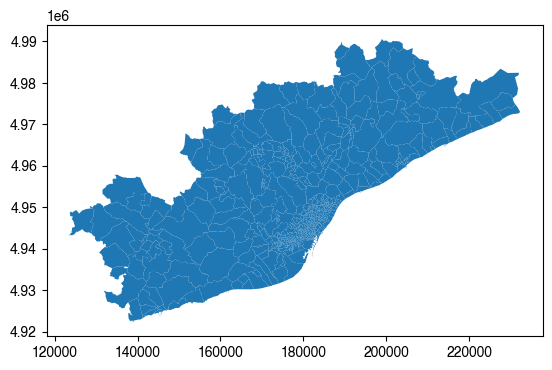

In [45]:
gdf_RMB_total_with_selected_features.plot()

## Load land use features for TAZs (Clean)

In [49]:
gdf_RMB_total_with_selected_features.to_file("../../01-data/EMO96_TAZ_data/gdf_RMB_total_with_selected_features_esri54009_v2.gpkg", driver='GPKG')

In [50]:
gdf_RMB_total_with_selected_features = gpd.read_file("../../01-data/EMO96_TAZ_data/gdf_RMB_total_with_selected_features_esri54009_v2.gpkg")
gdf_RMB_total_with_selected_features = gdf_RMB_total_with_selected_features.to_crs("esri:54009")

In [53]:
gdf_RMB_total_with_selected_features.head(3)

,index,SUM_POBLAC,LTL,ESTUDIANTS,SHAPE_AREA,SHAPE_LEN,t1_1,t2_1,t2_2,t3_1,...,ratio_GHSL_built_resMidLow_3to6m,ratio_GHSL_built_nonresMid_6to15m,ratio_GHSL_built_nonresMidLow_3to6m,ratio_GHSL_built_nonresLow_below3m,ratio_GHSL_built_below3m,ratio_GHSL_built_3to6m,ratio_GHSL_built_6to15m,ratio_GHSL_built_15to30m,ratio_GHSL_built_over30m,geometry
0,08019069,18118.0,3151.0,1758.0,326841.283357,2748.517198,18705.320626,0.530282,0.469718,45.543015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000917,0.536533,0.000000,"POLYGON ((178096.262 4942353.380, 178158.136 4..."
1,08019070,5625.0,5421.0,754.0,218110.222731,2469.312925,5569.990947,0.541751,0.458249,46.849650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.444343,0.015575,"POLYGON ((178427.235 4944013.370, 178479.021 4..."
2,08019071,15776.0,2816.0,1191.0,279857.176398,2293.920831,14678.296663,0.532279,0.467721,47.534256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.002140,0.470399,0.028887,"POLYGON ((178448.676 4943184.150, 178425.104 4..."


In [60]:
for col in gdf_RMB_total_with_selected_features.columns:
    if col.startswith("ratio"):
        print(col)

ratio_surface_O_per_V
ratio_surface_C_per_V
ratio_surface_E_per_V
ratio_surface_Y_per_V
ratio_surface_I_per_V
ratio_surface_G_per_V
ratio_surface_A_per_V
ratio_surface_K_per_V
ratio_surface_T_per_V
ratio_workers
ratio_students
ratio_OSM_length_roads_motorways
ratio_OSM_length_roads_non_motorways
ratio_OSM_length_roads_trunk
ratio_OSM_length_roads_primary
ratio_OSM_length_roads_secondary
ratio_OSM_length_roads_tertiary
ratio_OSM_length_roads_minor
ratio_GHSL_open_lowVeg
ratio_GHSL_open_midVeg
ratio_GHSL_open_hiVeg
ratio_GHSL_open_roads
ratio_GHSL_built_resMid_6to15m
ratio_GHSL_built_resMidHi_15to30m
ratio_GHSL_built_nonresMidHi_15to30m
ratio_GHSL_none
ratio_GHSL_built_resHi_over30m
ratio_GHSL_open_water
ratio_GHSL_built_nonresHi_over30m
ratio_GHSL_built_resLow_below3m
ratio_GHSL_built_resMidLow_3to6m
ratio_GHSL_built_nonresMid_6to15m
ratio_GHSL_built_nonresMidLow_3to6m
ratio_GHSL_built_nonresLow_below3m
ratio_GHSL_built_below3m
ratio_GHSL_built_3to6m
ratio_GHSL_built_6to15m
ratio_GHSL_b

# Targeted areas
From EY report

In [17]:
EY_arroba22 = gpd.read_file("../../01-data/EY/BCN_EMO96_EY_arroba22.shp")
EY_pgracia = gpd.read_file("../../01-data/EY/BCN_EMO96_EY_pgracia.shp")
EY_diagonalmacia = gpd.read_file("../../01-data/EY/BCN_EMO96_EY_diagonalmacia.shp")
EY_portvell = gpd.read_file("../../01-data/EY/BCN_EMO96_EY_portvell.shp")
EY_firanova = gpd.read_file("../../01-data/EY/BCN_EMO96_EY_firanova.shp")
EY_firanova_c32 = gpd.read_file("../../01-data/EY/BCN_EMO96_EY_firanova_c32.shp")
EY_RBD_ctarragona = gpd.read_file("../../01-data/EY/BCN_EMO96_EY_RBD_ctarragona.shp")
EY_RBD_resteixamplediagonal = gpd.read_file("../../01-data/EY/BCN_EMO96_EY_RBD_resteixamlediagonal.shp")
EY_RC_restcity_additional = gpd.read_file("../../01-data/EY/BCN_EMO96_EY_RC_restcity_additional_areas.shp")
EY_RC_restcity = gpd.read_file("../../01-data/EY/BCN_EMO96_EY_RC_restcity.shp")

In [18]:
list_shp_EY = [
EY_pgracia,
EY_portvell,
EY_firanova,
EY_RBD_ctarragona,
EY_RBD_resteixamplediagonal,
EY_RC_restcity_additional,
EY_RC_restcity,
]

In [19]:
EMO96_target_areas = {}
EMO96_target_areas["22arroba"] = list(EY_arroba22["CZT"])
EMO96_target_areas["CBD_pgracia"] = list(EY_pgracia["CZT"])
EMO96_target_areas["CBD_diagonalmacia"] = list(EY_diagonalmacia["CZT"])
EMO96_target_areas["NBA_portvell"] = list(EY_portvell["CZT"])
EMO96_target_areas["NBA_firanova"] = list(EY_firanova["CZT"])
EMO96_target_areas["NBA_firanova_c32"] = list(EY_firanova_c32["CZT"])
EMO96_target_areas["RBD_ctarragona"] = list(EY_RBD_ctarragona["CZT"])
EMO96_target_areas["RBD_resteixamplediagonal"] = list(EY_RBD_resteixamplediagonal["CZT"])
EMO96_target_areas["restcity"] = list(EY_RC_restcity["CZT"])
EMO96_target_areas["restcity_additional"] = list(EY_RC_restcity_additional["CZT"])

## create three different areas of intervention

Areas_inter_01 (*Area A1* in the paper) covers the 66 zones analyzed in the report that are located in the core of the RMB, including some of the premium locations for offices. 

Areas_inter_02 (*Area A2* in the paper) is the subset of Area A1 of 47 zones considered suitable for conversion of offices into housing but does not contain high-end locations. Despite the relatively small extension, this accounts for almost 20 % of the office space in the RMB, with a larger-than-average size of office units. 

Finally, Areas_inter_03 (*Area B* in the paper) includes the 147 zones of the RMB, whose proportion of built-up office space is above average. These zones are scattered across the RMB and account for a large proportion of urban mixed-use.

In [22]:
areas_inter_01 =[]
for key in EMO96_target_areas:
    if (key != "22arroba") or (key != "CBD_pgracia") or (key != "NBA_firanova_c32"):
        areas_inter_01+=EMO96_target_areas[key]
print(f"Areas 01 (Areas A1) includes {len(areas_inter_01)} zones")

Areas 01 includes 66 zones


<Axes: >

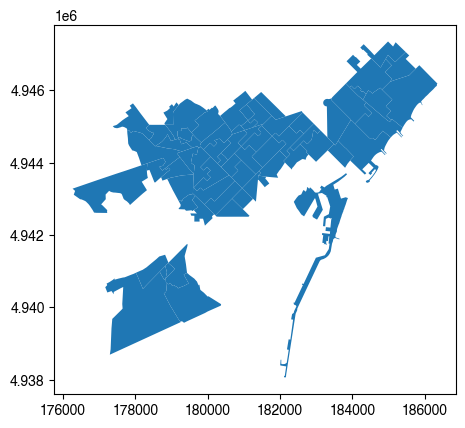

In [77]:
gdf_RMB_total_with_selected_features.loc[areas_inter_01].plot()

In [23]:
areas_inter_02 =[]
for key in EMO96_target_areas:
    # if (key != "22arroba"):# or (key != "CBD_pgracia") or (key != "NBA_firanova_c32"):
    if (key != "22arroba") and (key != "CBD_pgracia") and (key != "NBA_firanova_c32"):
    # if (key == "NBA_firanova_c32"):
        areas_inter_02+=EMO96_target_areas[key]
print(f"Areas 02 (Areas A2) includes {len(areas_inter_02)} zones")

Areas 02 includes 47 zones


<Axes: >

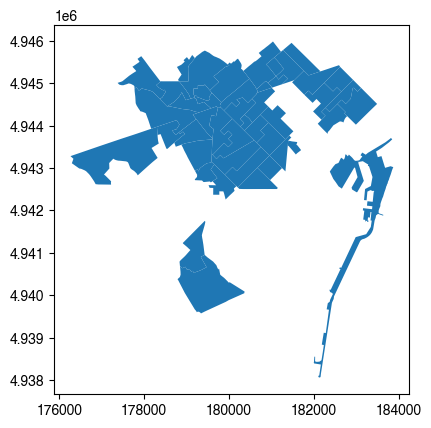

In [78]:
gdf_RMB_total_with_selected_features.loc[areas_inter_02].plot()

In [68]:
# Compute total built-up area per row
gdf_RMB_total_with_selected_features["total_built_up"] = gdf_RMB_total_with_selected_features[
    [
        "area_const_x__sum__V",
        "area_const_x__sum__C",
        "area_const_x__sum__O",
        "area_const_x__sum__E",
        "area_const_x__sum__A",
    ]
].sum(axis=1)

# Compute percentage of office area
gdf_RMB_total_with_selected_features["office_percentage"] = (
    gdf_RMB_total_with_selected_features["area_const_x__sum__O"]
    / gdf_RMB_total_with_selected_features["total_built_up"]
) 

# Compute mean percentage of office area
mean_office_percentage = gdf_RMB_total_with_selected_features["office_percentage"].mean()

# Get list of indexes where office_percentage is above the mean
areas_inter_03 = gdf_RMB_total_with_selected_features[
    gdf_RMB_total_with_selected_features["office_percentage"] > mean_office_percentage
].index.tolist()

# Print or use the list
print(f"Areas 03 (Areas B) includes {len(areas_inter_03)} zones")

Areas 03 (Areas B) includes 142 zones


<Axes: >

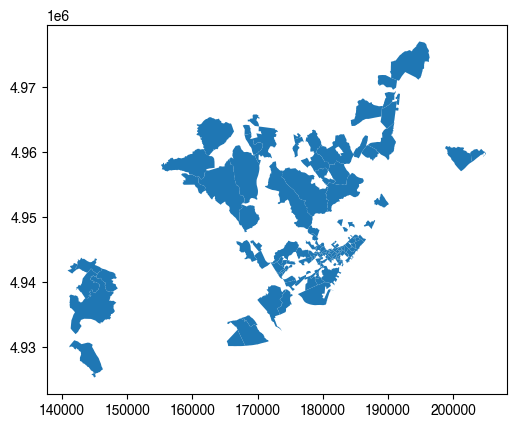

In [69]:
gdf_RMB_total_with_selected_features.loc[areas_inter_03].plot()

# Interventions

In [79]:
%%time
def create_zipf_gravity_terms_ine_cadaster(row):
    # dist = row.quickest_traveltime_3
    dist = row.quickest_traveltime + 1
    cadaster_agg = "area_const_x__sum" #count_per_km2, count, area_m2_per_km2, area_const_x__sum
    ine_cadaster_metrics_list = [
        "SUM_POBLAC",
        "LTL",
        "ESTUDIANTS",
        "t1_1", # total pop
        "t2_1",
        "t3_1", # 
        "t4_2", # % pop 16-64 years old
        "avg_income_per_person_2019",
        f"{cadaster_agg}__V",
        f"{cadaster_agg}__O",
        f"{cadaster_agg}__C",
        f"{cadaster_agg}__I",
        f"{cadaster_agg}__E",
        f"{cadaster_agg}__G",
        f"{cadaster_agg}__Y",
        f"{cadaster_agg}__A",
        f"{cadaster_agg}__K",
        f"{cadaster_agg}__T"
    ]
    for metric in ine_cadaster_metrics_list:
        o_metric = row["o_{}".format(metric)]
        d_metric = row["d_{}".format(metric)]
        zipf = o_metric*d_metric/dist
        row["zipf_gravity_{}".format(metric)] = zipf
    return row

CPU times: user 9 μs, sys: 2 μs, total: 11 μs
Wall time: 19.8 μs


## Test (intervention 01)

Transfer all office space to housing space 

Keeping the average number of people per housing square as population increase

In [80]:
# simplest intervention. Pass (proportion based on ratio) office space to housing, and increase population accordingly (and all related metrics)
def intervention_01(row, areas, OtoV_conversion_factor=1):
    if row.name in areas:
        # conversion factor from Office to Housing (Viviendas)
        OtoV_conversion_factor = OtoV_conversion_factor
        
        area = row.SHAPE_AREA
        # surface Offices
        built_area_O = row.area_const_x__sum__O
        # surface Housing (Viviendas)
        built_area_V = row.area_const_x__sum__V
        #population
        pop = row.t1_1
        workers = row.LTL

        # all offices allocated as new residential space
        add_built_area_V = built_area_O * OtoV_conversion_factor

        # ratio of people per squaremeter of housing
        ratio_pop_area_V = pop/built_area_V

        # additional pop for new housing
        add_pop = add_built_area_V*ratio_pop_area_V # we assume that the ratio of people per housing unit does not change
        row["add_pop"] = add_pop

        # update pop
        new_pop = pop + add_pop
        row["t1_1"] = new_pop

        # ratio of workers per population
        ratio_workers_pop = row["ratio_workers"]# workers/pop

        # update workers for new housing (assuming same ratio)
        new_workers = new_pop*ratio_workers_pop
        row["LTL"] = new_workers

        # update density
        new_density = new_pop/area
        row["pop_dens_inh_per_km2"] = new_density

        # update housing built up area
        new_built_area_V = built_area_V + add_built_area_V
        row["area_const_x__sum__V"] = new_built_area_V

        # update office built up area
        row["area_const_x__sum__O"] = row["area_const_x__sum__O"] *(1-OtoV_conversion_factor)
        
        # print("In zone {}, + {} inhabitants".format(row.name, add_pop))
    
    return row

## Intervention 02

Transfer all office space to housing space (V), commerce (C), education (E) and storage/parking (A)

Measure the average number of people per housing square as increase of population.

In [80]:
# simplest intervention. Pass (proportion based on ratio) office space to housing, and increase population accordingly (and all related metrics)
def intervention_02(row, areas, OtoOTHER_conversion_factor=1):
    if row.name in areas:
        
        area = row.SHAPE_AREA
        # surface Offices
        built_area_O = row.area_const_x__sum__O
        # surface Housing (Viviendas)
        built_area_V = row.area_const_x__sum__V
        # surface Commerce
        built_area_C = row.area_const_x__sum__C
        # surface Education
        built_area_E = row.area_const_x__sum__E
        # surface Storage/parking
        built_area_A = row.area_const_x__sum__A
        #population
        pop = row.t1_1
        workers = row.LTL

        # compute distribution of uses
        non_O_built_area = built_area_V + built_area_C + built_area_E + built_area_A
        ratio_area_V = built_area_V/non_O_built_area
        ratio_area_C = built_area_C/non_O_built_area
        ratio_area_E = built_area_E/non_O_built_area
        ratio_area_A = built_area_A/non_O_built_area
        
        #  offices allocated as other land uses (V, C, E, A) space preserving the distribution
        add_built_area_V = built_area_O * OtoOTHER_conversion_factor * ratio_area_V
        add_built_area_C = built_area_O * OtoOTHER_conversion_factor * ratio_area_C
        add_built_area_E = built_area_O * OtoOTHER_conversion_factor * ratio_area_E
        add_built_area_A = built_area_O * OtoOTHER_conversion_factor * ratio_area_A

        # ratio of people per squaremeter of housing
        ratio_pop_area_V = pop/built_area_V

        # additional pop for new housing
        add_pop = add_built_area_V*ratio_pop_area_V # we assume that the ratio of people per housing unit does not change
        row["add_pop"] = add_pop

        # update pop
        new_pop = pop + add_pop
        row["t1_1"] = new_pop

        # ratio of workers per population
        ratio_workers_pop = row["ratio_workers"]# workers/pop

        # update workers for new housing (assuming same ratio)
        new_workers = new_pop*ratio_workers_pop
        row["LTL"] = new_workers

        # update density
        new_density = new_pop/area
        row["pop_dens_inh_per_km2"] = new_density

        # update other uses built up area
        new_built_area_V = built_area_V + add_built_area_V
        row["area_const_x__sum__V"] = new_built_area_V
        new_built_area_C = built_area_C + add_built_area_C
        row["area_const_x__sum__C"] = new_built_area_C
        new_built_area_E = built_area_E + add_built_area_E
        row["area_const_x__sum__E"] = new_built_area_E
        new_built_area_A = built_area_A + add_built_area_A
        row["area_const_x__sum__A"] = new_built_area_A

        # update office built up area
        row["area_const_x__sum__O"] = row["area_const_x__sum__O"] *(1-OtoV_conversion_factor)
        
        # print("In zone {}, + {} inhabitants".format(row.name, add_pop))
    
    return row

# Apply tranformations

With the changes  in the zone features, it is needed to recompute all the lagged variables

## Lagged variables

#### Graph distances adjacency

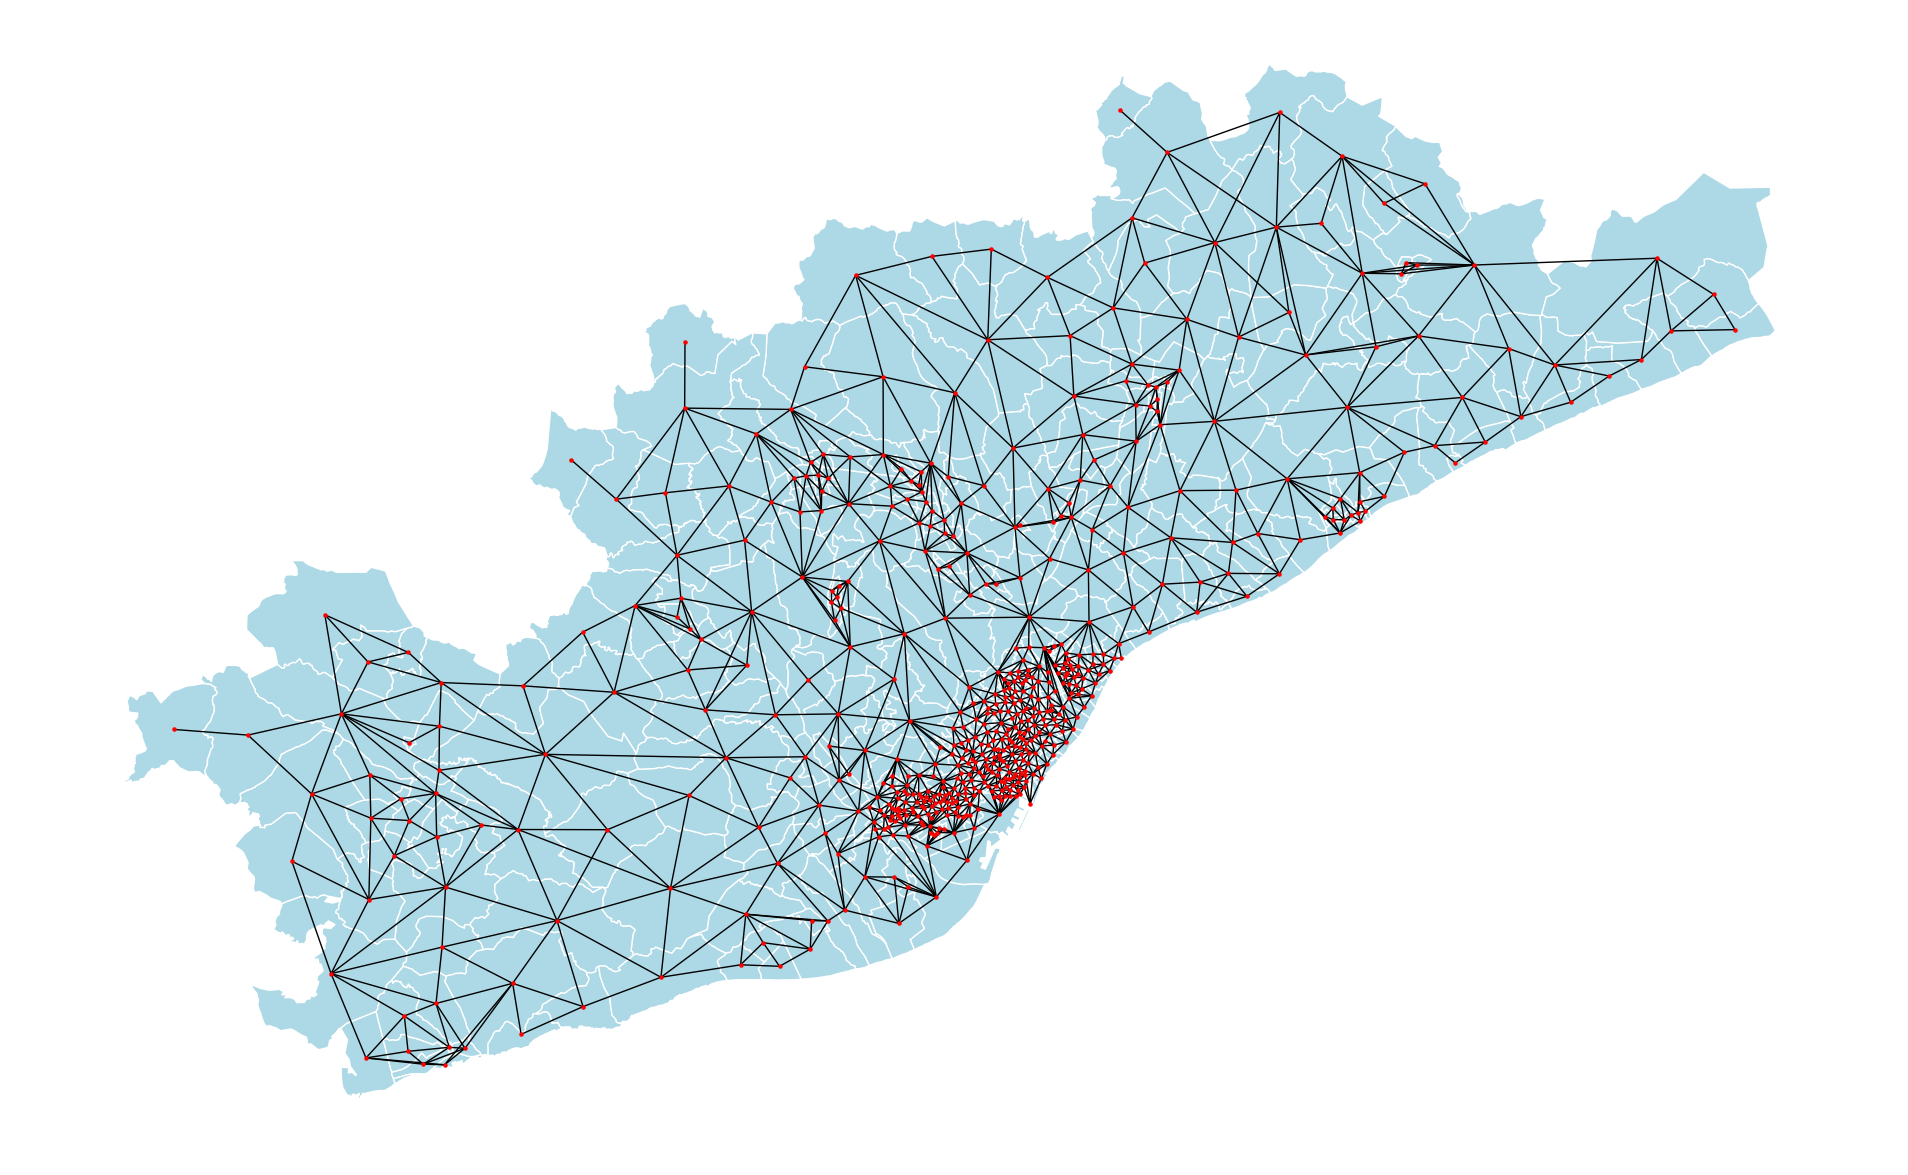

In [84]:
from libpysal import weights
import geopandas as gpd
import networkx as nx
import numpy as np

# Assuming you have a GeoDataFrame gdf_RMB_total_with_features with a 'geometry' column and zones ids as indexes
gdf_RMB_total_with_features = gdf_RMB_total_with_features

# extract the centroids for connecting the regions, which is
# the average of the coordinates that define the polygon's boundary
centroids = np.column_stack((gdf_RMB_total_with_features.centroid.x, gdf_RMB_total_with_features.centroid.y))

# construct the "Queen" adjacency graph
queen = weights.Queen.from_dataframe(gdf_RMB_total_with_features)

# Convert the graph to a networkx object
graph = queen.to_networkx()

# To plot with networkx, we need to merge the nodes back to
# their positions in order to plot in networkx
positions = dict(zip(graph.nodes, centroids))

# plot with a nice basemap
fig, ax = plt.subplots(1, 1, figsize=(30,15))
ax = gdf_RMB_total_with_features.plot(linewidth=1, edgecolor="white", facecolor="lightblue", ax=ax)
ax.axis("off")

# Draw the graph on the plot
nx.draw(graph, positions, ax=ax, node_size=5, node_color="r")
plt.show()

# Compute the matrix with degrees of separation
degree_matrix = nx.floyd_warshall_numpy(graph)

# Convert the matrix to a DataFrame with the same indexes and columns
degree_df = pd.DataFrame(degree_matrix, index=gdf_RMB_total_with_features.index, columns=gdf_RMB_total_with_features.index)

## Opening OD matrix
Needed for lagged variables

In [85]:
import os, fiona, copy
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x) #disable scientific notation for pandas

In [86]:
# Taking the excel matrix file and cropping it to match its scope with the studied area according to the given SHP file. iT

def filtering_xlsxMat_OD(OD_matrix, shp_zones_origin, shp_zones_dest):
#     # Open Matrix
#     OD = pd.read_excel(xlsx_mat_path, engine='openpyxl', index_col=0)
    # Convert names of zones to string and correct the name of the zones with missing leading 0
    
    OD.columns = OD.columns.astype(str)
    OD.index = OD.index.astype(str)
    
    for i in range(len(OD.columns.values)):
        if OD.columns.values[i].startswith('8'):
            OD.columns.values[i] = "0{}".format(OD.columns.values[i])

    for i in range(len(OD.index.values)):
        if OD.index.values[i].startswith('8'):
            OD.index.values[i] = "0{}".format(OD.index.values[i])
    
    # Filtering rows and cols based on the shp file

    # reading shp file
    shp_file_origen = shp_zones_origin
    shp_file_dest = shp_zones_dest

    shp_origen = fiona.open(shp_file_origen, 'r')
    shp_dest = fiona.open(shp_file_dest, 'r')

    list_of_zones_origen = []
    for elem in shp_origen:
        zone_code = elem['properties']['CZT']
        if zone_code.startswith('8'):
            zone_code = "0{}".format(zone_code)                 
        list_of_zones_origen.append(zone_code)
    
    list_of_zones_dest = []
    for elem in shp_dest:
        zone_code = elem['properties']['CZT']
        if zone_code.startswith('8'):
            zone_code = "0{}".format(zone_code)                 
        list_of_zones_dest.append(zone_code)
    
    # Applying mask
    OD_result = OD[list_of_zones_dest]
    OD_result = OD_result.loc[list_of_zones_origen]
    
    return OD_result

In [87]:
# Original OD matrix from source

# OD_matrix_path = r'..\..\data\ATM\source\od\MATRIU_VL_CALIBRADA_Idom_clean.xlsx'
OD_matrix_path = "../../01-data/ATM/source/od/MATRIU_VL_CALIBRADA_Idom_clean.xlsx"
OD = pd.read_excel(OD_matrix_path, engine='openpyxl', index_col=0)

# shp_RMB_TOTAL = r"..\..\data\ATM\proc\shp\EMO96_IDESCAT_RMB_TOTAL\EMO96_RMB_TOTAL.shp"
shp_RMB_TOTAL = r"../../01-data/ATM/proc/shp/EMO96_IDESCAT_RMB_TOTAL/EMO96_RMB_TOTAL.shp"

In [88]:
OD

,8015018,8015019,8015006,8015021,8015022,8015004,8015002,8015001,8015003,8015020,...,Ext_056,Ext_057,Ext_058,Ext_059,Ext_060,Ext_061,Ext_062,Ext_063,Ext_064,Ext_065
Name,,,,,,,,,,,,,,,,,,,,,
8015018,936.30,447.46,445.89,728.10,636.47,637.39,442.27,902.64,1274.14,412.86,...,32.34,0.00,0.00,0.11,0.21,1.96,0.00,0.00,0.00,0.00
8015019,447.41,670.96,606.02,831.24,467.91,271.44,359.81,636.40,945.42,375.48,...,29.02,0.00,0.00,0.10,0.13,1.19,0.00,0.00,0.00,0.00
8015006,445.82,606.00,747.58,466.06,584.01,61.81,153.53,493.04,433.48,149.26,...,30.38,0.00,0.00,0.06,0.02,0.25,0.00,0.00,0.00,0.00
8015021,728.09,831.31,466.12,1307.28,851.84,626.21,310.33,807.34,442.88,511.52,...,46.04,0.00,0.00,0.07,21.98,1.33,0.00,0.00,0.00,0.00
8015022,636.44,467.94,584.07,851.81,1503.55,460.46,440.10,806.22,408.44,392.51,...,66.40,0.00,0.00,0.52,0.22,2.15,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ext_061,3.44,1.92,0.38,1.47,2.52,0.99,0.72,2.30,0.23,1.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Ext_062,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Ext_063,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [89]:
df_OD_RMB_TOTAL =  filtering_xlsxMat_OD(OD, shp_RMB_TOTAL, shp_RMB_TOTAL)

## compute lagged variables
ref: https://geographicdata.science/book/notebooks/11_regression.html#exogenous-effects-the-slx-model

In [90]:
import libpysal
import numpy as np
from libpysal.weights import W
from scipy.sparse import csr_matrix

In [91]:
## lagged OD variables (i.e. flows)
def lag_vars(OD_mat, weights):
    w_od_mat = (
    # take all variables except geometry
    OD_mat
        # Compute the spatial lag of each of those variables
    .apply(
        lambda y: libpysal.weights.spatial_lag.lag_spatial(weights, y)
        # Rename the spatial lag, adding w_ to the original name
    )
    )
    return w_od_mat

# vectorize lagged dependent variable
def vectorize_matrix(matrix, column_name):
    origins = matrix.index.values.tolist()
    destinations = list(matrix.columns)
    total_num_of_trips = 0
    # df_new = pd.DataFrame(columns=["origin", "destination", "value"])
    list_of_origins = []
    list_of_dests = []
    list_of_values = []
    for origin in origins:
        for dest in destinations:

            list_of_origins.append(origin)
            list_of_dests.append(dest)
            value = matrix.loc[origin, dest]
            list_of_values.append(value)

    frame = {'origin':list_of_origins, 'destination':list_of_dests, column_name:list_of_values}
    df_vectorized_matrix = pd.DataFrame(frame)
    return df_vectorized_matrix

def add_lagged_OD_matrix_values(target_df, OD_mat, weights, column_name):
    w_od_mat = lag_vars(OD_mat, weights)
    df_vectorized_matrix = vectorize_matrix(w_od_mat, column_name)
    return target_df.merge(df_vectorized_matrix, left_on=["origin", "destination"], right_on=["origin", "destination"])
    # return df_OD_vect_on_origin

In [92]:
def compute_lagged_variables(df_OD_vect_on_origin):
    W_queen_zones_R = libpysal.weights.Queen.from_dataframe(gdf_RMB_total_with_features, ids=list(gdf_RMB_total_with_features.index)) 
    
    W_queen_zones_R.transform = "R"
    
    # lagged zone features with Queen weights
    wq_R = (
        # take all variables except geometry
        gdf_RMB_total_with_selected_features.drop("geometry", axis=1)
            # Compute the spatial lag of each of those variables
        .apply(
            lambda y: libpysal.weights.spatial_lag.lag_spatial(W_queen_zones_R, y)
            # Rename the spatial lag, adding w_ to the original name
        )
        .rename(
            columns=lambda c: "Wq_R_"
            + c
            # Remove the lag of the binary variable for apartments
        )
    )
    
    df_OD_vect_on_origin = df_OD_vect_on_origin.merge(wq_R.add_prefix("o_"), left_on="origin", right_index=True, how="left")
    df_OD_vect_on_origin = df_OD_vect_on_origin.merge(wq_R.add_prefix("d_"), left_on="destination", right_index=True, how="left")
    
    
    ## create W matrix for simultaneous neighbors in origin and destination, for creating a third W term for the dependent variable: flows

    # Assuming adj_matrix is the original adjacency matrix and od_matrix is the OD matrix
    # Make sure they are both numpy arrays with the correct dimensions

    # Example adjacency matrix (replace this with your actual adjacency matrix)
    # adj_matrix = np.random.randint(2, size=(577, 577))
    W_queen_zones_origin_centric = libpysal.weights.Queen.from_dataframe(gdf_RMB_total_with_features, ids=list(gdf_RMB_total_with_features.index)) 
    adj_matrix = W_queen_zones_R.to_sparse().todense()

    # Example OD matrix (replace this with your actual OD matrix)
    od_matrix = df_OD_RMB_TOTAL

    # Find zones that are simultaneously adjacent for both origins and destinations
    simultaneously_adjacent = np.logical_and(adj_matrix, adj_matrix.T)

    # Create a new adjacency matrix based on the simultaneously adjacent zones
    new_adj_matrix = np.zeros_like(adj_matrix)

    # Iterate through each zone
    for i in range(len(df_OD_RMB_TOTAL.index)):
        for j in range(len(df_OD_RMB_TOTAL.columns)):
            # If the zone is simultaneously adjacent for both origin and destination, set it to 1
            if simultaneously_adjacent[i, j]:
                new_adj_matrix[i, j] = 1

    # Print the new adjacency matrix
    # print(new_adj_matrix)
    # Convert the new_adj_matrix to a sparse matrix (CSR format)
    sparse_new_adj_matrix = csr_matrix(new_adj_matrix)

    W_queen_OD_flows = W.from_sparse(sparse_new_adj_matrix)
    print("basic weights computed")
    ################
    
    keys_list = []
    for key in W_queen_zones_R.neighbor_offsets:
        keys_list.append(key)
    keys_list == list(df_OD_RMB_TOTAL.index)
    
    ################
    df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, df_OD_RMB_TOTAL, W_queen_zones_R, "Wq_R_o_daily_flow") # for origin centric
    df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, df_OD_RMB_TOTAL.T, W_queen_zones_R, "Wq_R_d_daily_flow") # for destination centric
    df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, df_OD_RMB_TOTAL, W_queen_OD_flows, "Wq_R_od_daily_flow") # for od simultaneous areas in origin and destination
    print("lagged daily flow computed")
    ################
    
    quickest_traveltime_3_OD_mat = df_OD_vect_on_origin.pivot(index='origin', columns='destination', values='quickest_traveltime').reindex(df_OD_RMB_TOTAL.index)[df_OD_RMB_TOTAL.columns.to_list()]

    df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, 
                                quickest_traveltime_3_OD_mat, 
                                W_queen_zones_R, "Wq_R_quickest_traveltime")

    # reciprocate
    df_OD_vect_on_origin["inv_quickest_traveltime"] = 1/(df_OD_vect_on_origin["quickest_traveltime"]+1) # for whole final df

    # lagged
    inv_quickest_traveltime_3_OD_mat = 1/(quickest_traveltime_3_OD_mat+1)

    df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, 
                                inv_quickest_traveltime_3_OD_mat, 
                                W_queen_zones_R, "Wq_R_inv_quickest_traveltime")
    print("lagged traveltime computed")
    ###################
    
    df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, 
                            degree_df.reindex(df_OD_RMB_TOTAL.index)[df_OD_RMB_TOTAL.columns.to_list()], 
                            W_queen_zones_R, "Wq_R_graph_degree")

    df_OD_vect_on_origin["inv_graph_degree"] = 1/(df_OD_vect_on_origin["graph_degree"] + 1)

    inv_degree_df = 1/(degree_df + 1)

    df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, 
                                inv_degree_df.reindex(df_OD_RMB_TOTAL.index)[df_OD_RMB_TOTAL.columns.to_list()], 
                                W_queen_zones_R, "Wq_R_inv_graph_degree")
    
    print("lagged net degree computed")
    #####################
    
    # for distance/network based centrality variables
    centrality_vars = ["quickest_route_centrality_mean",
    # "quickest_route_centrality_median",
    # "quickest_route_centrality_std",
    "quickest_route_centrality_max",
    "quickest_route_centrality_min"]

    print(f"centrality vars to process: {centrality_vars}")
    for var in centrality_vars:
        print(f"procesing {var}")
        zipf_OD_mat = df_OD_vect_on_origin.pivot(index='origin', columns='destination', values=var).reindex(df_OD_RMB_TOTAL.index)[df_OD_RMB_TOTAL.columns.to_list()] # make OD matrix and match geom index order

        # df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, 
        #                             zipf_OD_mat, 
        #                             W_queen_zones_D, f"Wq_D_{var}")
        df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, 
                                    zipf_OD_mat, 
                                    W_queen_zones_R, f"Wq_R_{var}")
    
    print("lagged centrality net computed")
    ############
    
    income_diff_OD_mat = df_OD_vect_on_origin.pivot(index='origin', columns='destination', values='income_diff').reindex(df_OD_RMB_TOTAL.index)[df_OD_RMB_TOTAL.columns.to_list()]

    df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, 
                                income_diff_OD_mat, 
                                W_queen_zones_R, "Wq_R_income_diff")

    # reciprocate
    df_OD_vect_on_origin["inv_income_diff"] = 1/(df_OD_vect_on_origin["income_diff"] + 1) # for whole final df

    # lagged
    inv_income_diff_OD_mat = 1/(income_diff_OD_mat+1)

    df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, 
                                inv_income_diff_OD_mat, 
                                W_queen_zones_R, "Wq_R_inv_income_diff")
    
    print("lagged income diffs computed")
    
    # add W for adjacency and internal
    adjacent_OD_mat = df_OD_vect_on_origin.pivot(index='origin', columns='destination', values='adjacent').reindex(df_OD_RMB_TOTAL.index)[df_OD_RMB_TOTAL.columns.to_list()]

    df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, 
                                adjacent_OD_mat, 
                                W_queen_zones_R, "Wq_R_adjacent")

    internal_OD_mat = df_OD_vect_on_origin.pivot(index='origin', columns='destination', values='internal').reindex(df_OD_RMB_TOTAL.index)[df_OD_RMB_TOTAL.columns.to_list()]

    df_OD_vect_on_origin = add_lagged_OD_matrix_values(df_OD_vect_on_origin, 
                                internal_OD_mat, 
                                W_queen_zones_R, "Wq_R_internal")
    print("lagged internal and adjacent computed")
    
    
    return df_OD_vect_on_origin
    
def add_transformations(df_OD_vect_on_origin):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for c in [c for c in df_OD_vect_on_origin.columns if df_OD_vect_on_origin[c].dtype in numerics]:
        # print(c)
        # all_data["log_{}".format(c)] = np.log10(all_data[c] + 1)
        df_OD_vect_on_origin["log_{}".format(c)] = np.log1p(df_OD_vect_on_origin[c])
        df_OD_vect_on_origin["cbrt_{}".format(c)] = np.cbrt(df_OD_vect_on_origin[c])
        # try:
        #     all_data["yj_{}".format(c)], lam = yeojohnson(all_data[c])
        # except:
        #     print("\tYJ failed")
        # all_data["rec_{}".format(c)] = np.reciprocal(all_data[c] + 1)
        df_OD_vect_on_origin["sqrt_{}".format(c)] = np.sqrt(df_OD_vect_on_origin[c])
    return df_OD_vect_on_origin

def rename_cols(df_OD_vect_on_origin):
    #### Renaming ######
    df_OD_vect_on_origin.columns = [col.replace("superficie", "area") for col in df_OD_vect_on_origin.columns]
    df_OD_vect_on_origin.columns = [col.replace("año_antiguedad|count", "count") for col in df_OD_vect_on_origin.columns]
    df_OD_vect_on_origin.columns = [col.replace("año_antiguedad", "year") for col in df_OD_vect_on_origin.columns]
    df_OD_vect_on_origin.columns = [col.replace("construida", "const") for col in df_OD_vect_on_origin.columns]
    df_OD_vect_on_origin.columns = [col.replace("|", "__") for col in df_OD_vect_on_origin.columns]
    df_OD_vect_on_origin.columns = [col.replace("/", "_per_") for col in df_OD_vect_on_origin.columns]
    df_OD_vect_on_origin.columns = [col.replace("d_Wq_R_", "Wq_R_d_") for col in df_OD_vect_on_origin.columns]
    df_OD_vect_on_origin.columns = [col.replace("o_Wq_R_", "Wq_R_o_") for col in df_OD_vect_on_origin.columns]
    
    return df_OD_vect_on_origin

## Open models

In [70]:
df_models = pd.read_pickle(f"../../01-data/results_models_for_daily_flow_w_vars_c_10007_log.pkl")

In [71]:
df_models

,OLS,XGB,Hurdle_XGB_logistic_00_y=0,Hurdle_XGB_tweedie_reg_y>0
base,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SAR_odw,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SAR_o,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SAR_d,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SAR_w,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SLX_odw,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SLX_od,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SDM_odw,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."


In [73]:
df_models.loc["base", "Hurdle_XGB_tweedie_reg_y>0"]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3495, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

## Wrappers and helpers to apply interventions

In [93]:
def generate_alternative(intervention, areas=areas_inter_01, factor=1):
    # modify zone information based on intervention
    if intervention == "intervention_01":
        gdf_RMB_total_with_features_after_intervention = gdf_RMB_total_with_selected_features.apply(lambda row: intervention_01(row, areas, factor), axis=1)
    elif intervention == "intervention_02":
         gdf_RMB_total_with_features_after_intervention = gdf_RMB_total_with_selected_features.apply(lambda row: intervention_02(row, areas), axis=1)                 
    print("Total pop. added:", gdf_RMB_total_with_features_after_intervention["add_pop"].sum())

    # merge with main dataset with vectorized and origin centric dyads
    ## for origins
    df_OD_vect_on_origin_alternative = all_data_copy.merge(gdf_RMB_total_with_features_after_intervention.add_prefix("o_"), left_on="origin", right_index=True, how="left")
    ## for destination
    df_OD_vect_on_origin_alternative = df_OD_vect_on_origin_alternative.merge(gdf_RMB_total_with_features_after_intervention.add_prefix("d_"), left_on="destination", right_index=True, how="left")

    # create zipf variables
    df_OD_vect_on_origin_alternative = df_OD_vect_on_origin_alternative.swifter.apply(lambda row: create_zipf_gravity_terms_ine_cadaster(row), axis=1)

    # compute lagged variables
    df_OD_vect_on_origin_alternative = compute_lagged_variables(df_OD_vect_on_origin_alternative)

    # transform columns
    df_OD_vect_on_origin_alternative = add_transformations(df_OD_vect_on_origin_alternative)

    # rename cols
    df_OD_vect_on_origin_alternative = rename_cols(df_OD_vect_on_origin_alternative)
    
    return df_OD_vect_on_origin_alternative

In [94]:
def make_interventions_forecast(data, model_type, df_models):
    # transformation = ""
    model_type = model_type
    features = vars_c_10007_log
    target = f"sqrt_daily_flow"
    data_ = data#all_data#[all_data.daily_flow>=1].drop(["o_geometry", "d_geometry"], axis=1).astype("float64")

    features = assemble_features(model_type, features, target)

    if model_type == "":
        model_logistic_reg = df_models.loc["base", "Hurdle_XGB_logistic_00_y=0"]
        model_non_zero_reg = df_models.loc["base", "Hurdle_XGB_tweedie_reg_y>0"]

    elif model_type == "SAR":
        model_logistic_reg = df_models.loc["SAR_odw", "Hurdle_XGB_logistic_00_y=0"]
        model_non_zero_reg = df_models.loc["SAR_odw", "Hurdle_XGB_tweedie_reg_y>0"]

    elif model_type == "SAR_w":
        model_logistic_reg = df_models.loc["SAR_w", "Hurdle_XGB_logistic_00_y=0"]
        model_non_zero_reg = df_models.loc["SAR_w", "Hurdle_XGB_tweedie_reg_y>0"]

    elif model_type == "SLX":
        model_logistic_reg = df_models.loc["SLX_odw", "Hurdle_XGB_logistic_00_y=0"]
        model_non_zero_reg = df_models.loc["SLX_odw", "Hurdle_XGB_tweedie_reg_y>0"]

    elif model_type == "SDM":
        model_logistic_reg = df_models.loc["SDM_odw", "Hurdle_XGB_logistic_00_y=0"]
        model_non_zero_reg = df_models.loc["SDM_odw", "Hurdle_XGB_tweedie_reg_y>0"]

    X_manual = data_[features]
    y_manual = data_[target]

    X_train, X_test, y_train, y_test = train_test_split(X_manual, y_manual, test_size=0.2, random_state=42)

    if target.split("_")[0] == "cbrt" or target.split("_")[0] == "log" or target.split("_")[0] == "sqrt":
        y_pred = check_fit_rescale((model_logistic_reg, model_non_zero_reg), data_, features, target,  model_type="mixed_1")
        eval_plot_pred("mixed_1_10007_log-sqrt SLX OPTIMIZED", all_data, y_pred)

    else:
        y_pred = check_fit((model_logistic_reg, model_non_zero_reg), data_, features, target, model_type="mixed_1")
        plot_hist(data_, y_pred)
    return y_pred

In [95]:
from IPython.utils import io

def wrapper_apply_interventions(intervention, areas, areas_name, factors, model_types, data_flows):
    
    # intervention: e.g. intervention_01
    # areas: e.g. areas_inter_01
    
    for factor in factors:
        print(f"computing factor {factor}")
        with io.capture_output() as captured: # hide output
            df_OD_vect_on_origin_intervention_01_factor = generate_alternative(intervention=intervention, areas=areas, factor=factor)
        for model_type in model_types:
            print(f"\tcomputing model {model_type}")
            with io.capture_output() as captured: #hide output
                y_pred = make_interventions_forecast(df_OD_vect_on_origin_intervention_01_factor, model_type, df_models)
            
            # rename labels
            if model_type == "": label_model_type= "base"
            elif model_type == "SAR": label_model_type= "SAR_odw"
            elif model_type == "SAR_w": label_model_type= "SAR_w"
            elif model_type == "SLX": label_model_type= "SLX_odw"
            elif model_type == "SDM": label_model_type= "SDM_odw"
            
            data_flows[f"daily_flows_inter[{intervention}]_area[{areas_name}]_factor{factor}_with_{label_model_type}"] = list(y_pred)
        
    return data_flows

In [96]:
# Assuming df is your DataFrame
filtered_columns = [col for col in data_flows.columns if 'inter[intervention_01]' not in col]
data_flows_filtered = data_flows[filtered_columns]
data_flows_filtered

,origin,destination,daily_flow
0,08019069,08019069,1181.62
1,08019069,08019070,83.87
2,08019069,08019071,49.90
3,08019069,08019072,66.35
4,08019069,08019073,0.00
...,...,...,...
332924,08904001,08307005,0.00
332925,08904001,08307006,0.00
332926,08904001,08307007,0.00
332927,08904001,08902001,0.00


In [97]:
# factors for ablation study
factors = [0.00, 0.005, 0.01, 0.015, 0.02, 0.025,
           0.08, 0.09, 0.10, 0.11, 0.12,
           0.18, 0.19, 0.20, 0.21, 0.22,
           # 0.23, 0.24, 0.25, 0.26, 0.27,
            0.28, 0.29, 0.30, 0.31, 0.32,
            0.38, 0.39, 0.40, 0.41, 0.42,
           0.48, 0.49, 0.50, 0.51, 0.52,
           0.58, 0.59, 0.60, 0.61, 0.62,
           0.68, 0.69, 0.70, 0.71, 0.72,
           # 0.73, 0.74, 0.75, 0.76, 0.77,
           0.78, 0.79, 0.80, 0.81, 0.82,
           0.88, 0.89, 0.90, 0.91, 0.92,
            0.93, 0.94, 0.95, 0.96, 0.97,
           0.98, 0.985, 0.99, 0.995, 1.00
          ]
# factors = [0.00]
model_types = ["", "SAR", "SAR_w", "SLX", "SDM"]

#### apply in batch
set as needed INTERVENTION = {intervention_01, intervention_02} and AREAS = {areas_inter_01, areas_inter_02, area_inter_03}}

In [76]:
INTERVENTION = "intervention_01"
AREAS = areas_inter_02
AREA_INTEREST = "areas_inter_02"
factors = [0.00, 0.005, 0.01, 0.015, 0.02, 0.025,
           0.08, 0.09, 0.10, 0.11, 0.12,
           0.18, 0.19, 0.20, 0.21, 0.22,
           # 0.23, 0.24, 0.25, 0.26, 0.27,
            0.28, 0.29, 0.30, 0.31, 0.32,
            0.38, 0.39, 0.40, 0.41, 0.42,
           0.48, 0.49, 0.50, 0.51, 0.52,
           0.58, 0.59, 0.60, 0.61, 0.62,
           0.68, 0.69, 0.70, 0.71, 0.72,
           # 0.73, 0.74, 0.75, 0.76, 0.77,
           0.78, 0.79, 0.80, 0.81, 0.82,
           0.88, 0.89, 0.90, 0.91, 0.92,
            0.93, 0.94, 0.95, 0.96, 0.97,
           0.98, 0.985, 0.99, 0.995, 1.00
          ]
model_types = ["", "SAR", "SAR_w", "SLX", "SDM"]

In [ ]:
%%time
data_flows = wrapper_apply_interventions(INTERVENTION, AREAS, AREA_INTEREST, factors, model_types, data_flows)

#### save and plot

In [110]:
# data_flows.to_pickle("../../01-data/data_flows_predictions_w_intervention_01_area_inter_02_a.pkl")
data_flows.to_pickle(f"../../01-data/data_flows_predictions_w_{INTERVENTION}_{AREA_INTEREST}_a.pkl")

In [77]:
# data_flows = pd.read_pickle("../../01-data/data_flows_predictions_w_intervention_01_area_inter_02_a.pkl")
data_flows = pd.read_pickle(f"../../01-data/data_flows_predictions_w_{INTERVENTION}_{AREA_INTEREST}_a.pkl")

#### plot

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re


def plot_ablation_from_intervention(data_flows):
    # Assuming data_flows is your DataFrame
    
    # Filter out columns that contain the substring "inter_"
    data_flows_filtered = data_flows.filter(regex='inter')
    
    from matplotlib.colors import ListedColormap
    
    list_colors = [
                "#E6E201",
            "#E64200",
            "#00E0BC",
            "#6400E0",
            "#2E8B7D",
    ]
    
    list_colors = [
        "indianred",
    "cornflowerblue",
        "gold",
    "mediumaquamarine",
       "coral",
    "plum",
    ]
    
    # Create a ListedColormap from the list of colors
    custom_cmap = ListedColormap(list_colors)
    
    # Create a custom palette from the list of colors
    custom_palette = sns.color_palette(list_colors)

    
    sum_of_models_df = data_flows_filtered.sum().reset_index()
    
    # Rename columns
    sum_of_models_df.columns = ['original_label', 'sum_of_values']
    
    
    
    # Extract the factor values from the model column
    sum_of_models_df['factor'] = sum_of_models_df['original_label'].str.extract(r'factor(\d+\.\d+)_').astype(float)
    
    # Extract the model names from the column names
    sum_of_models_df['model'] = sum_of_models_df['original_label'].str.extract(r'with_(.*)')
    
    sum_of_models_df['model'] = sum_of_models_df['model'].replace("base", "non-spatial")
    
    # remove perturbation in 0 (OPTIONAL)
    sum_of_models_df = sum_of_models_df[(sum_of_models_df.factor < 0.005) | (sum_of_models_df.factor > 0.025)]
    
    # display(sum_of_models_df)
    # Round values
    for index, row in sum_of_models_df.iterrows():
        factor = row.factor
        model = row.model
        if factor > 0.92 and factor < 0.98: sum_of_models_df.loc[index, 'factor_rounded'] = 0.95
        else: sum_of_models_df.loc[index, 'factor_rounded'] = round(factor, 1)
    
    ## Normalize
    for index, row in sum_of_models_df.iterrows():
        model = row.model
        max_sum_of_values = sum_of_models_df[
            (sum_of_models_df.factor == 0.00) & (sum_of_models_df.model == model)
        ].sum_of_values.values
        
        # Calculate the normalized value and assign it to a new column
        sum_of_models_df.loc[index, 'sum_of_values_norm'] = row['sum_of_values'] / max_sum_of_values

    # Define different markers for each model
    unique_models = sum_of_models_df['model'].unique()
    markers = ["o", "s", "D", "v", "^", "p", "*", "X"]  # Extend if needed
    model_markers = {model: markers[i % len(markers)] for i, model in enumerate(unique_models)}

    # Plot the lineplot
    plt.figure(figsize=(10, 6.7))
    plt.grid(visible=None, which='major', axis='y', color="gray", linestyle='--')
    
    ax = sns.lineplot(
        data=sum_of_models_df, 
        x='factor_rounded', 
        y='sum_of_values_norm', 
        hue='model', 
        style='model',  # Assign different markers per model
        markers=model_markers, 
        err_style="band", 
        palette=custom_palette
    )

    # Increase marker size manually
    for line in ax.get_lines():
        line.set_markersize(10)  # Adjust the size as needed
    
    plt.xlabel(f'Factor Value (office area to residential area): {INTERVENTION}')
    plt.ylabel('Ratio of flows (1 = no land use change)')
    plt.title(f'Prognosis total car flows (after {INTERVENTION} in {AREA_INTEREST})')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

    return sum_of_models_df

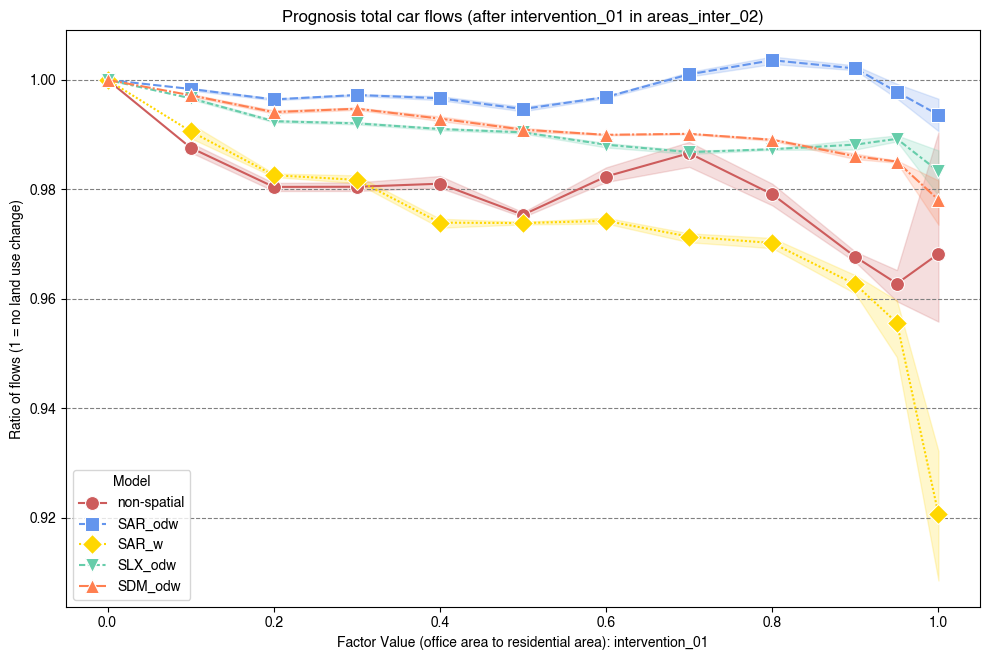

,original_label,sum_of_values,factor,model,factor_rounded,sum_of_values_norm
0,daily_flows_inter[intervention_01]_area[areas_...,6.908080e+06,0.0,non-spatial,0.0,1.000000
1,daily_flows_inter[intervention_01]_area[areas_...,6.211877e+06,0.0,SAR_odw,0.0,1.000000
2,daily_flows_inter[intervention_01]_area[areas_...,6.933004e+06,0.0,SAR_w,0.0,1.000000
3,daily_flows_inter[intervention_01]_area[areas_...,6.330323e+06,0.0,SLX_odw,0.0,1.000000
4,daily_flows_inter[intervention_01]_area[areas_...,6.355688e+06,0.0,SDM_odw,0.0,1.000000
...,...,...,...,...,...,...
300,daily_flows_inter[intervention_01]_area[areas_...,6.988111e+06,1.0,non-spatial,1.0,1.011585
301,daily_flows_inter[intervention_01]_area[areas_...,6.144022e+06,1.0,SAR_odw,1.0,0.989076
302,daily_flows_inter[intervention_01]_area[areas_...,6.218424e+06,1.0,SAR_w,1.0,0.896931
303,daily_flows_inter[intervention_01]_area[areas_...,6.176157e+06,1.0,SLX_odw,1.0,0.975647


In [85]:
plot_ablation_from_intervention(data_flows)

# Plot all

In [86]:
# data_flows = pd.read_pickle("../../01-data/data_flows_predictions_w_intervention_01_area_inter_02_a.pkl")
data_flows_list = list()
INTERVENTION, AREA_INTEREST = "intervention_01", "areas_inter_01"
data_flows = pd.read_pickle(f"../../01-data/data_flows_predictions_w_{INTERVENTION}_{AREA_INTEREST}_a.pkl")
data_flows_list.append(data_flows)

INTERVENTION, AREA_INTEREST = "intervention_02", "areas_inter_01"
data_flows = pd.read_pickle(f"../../01-data/data_flows_predictions_w_{INTERVENTION}_{AREA_INTEREST}_a.pkl")
data_flows_list.append(data_flows)

INTERVENTION, AREA_INTEREST = "intervention_01", "areas_inter_02"
data_flows = pd.read_pickle(f"../../01-data/data_flows_predictions_w_{INTERVENTION}_{AREA_INTEREST}_a.pkl")
data_flows_list.append(data_flows)

INTERVENTION, AREA_INTEREST = "intervention_02", "areas_inter_02"
data_flows = pd.read_pickle(f"../../01-data/data_flows_predictions_w_{INTERVENTION}_{AREA_INTEREST}_a.pkl")
data_flows_list.append(data_flows)

INTERVENTION, AREA_INTEREST = "intervention_01", "areas_inter_03"
data_flows = pd.read_pickle(f"../../01-data/data_flows_predictions_w_{INTERVENTION}_{AREA_INTEREST}_a.pkl")
data_flows_list.append(data_flows)

INTERVENTION, AREA_INTEREST = "intervention_02", "areas_inter_03"
data_flows = pd.read_pickle(f"../../01-data/data_flows_predictions_w_{INTERVENTION}_{AREA_INTEREST}_a.pkl")
data_flows_list.append(data_flows)

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_ablation_from_intervention_4x2(data_flows_list):

    # Create a figure with 3 rows and 2 columns of subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 20), sharex=True, sharey=True, dpi=150)
    axes = axes.flatten()

    list_cases_names = [
        "data_flows_01_01", "data_flows_02_01",
        "data_flows_01_02", "data_flows_02_02",
        "data_flows_01_03", "data_flows_02_03"
    ]

    list_colors = ["indianred", "cornflowerblue", "gold", "mediumaquamarine", "coral", "plum"]
    custom_palette = sns.color_palette(list_colors)

    markers = ["o", "s", "D", "v", "^", "p", "*", "X"]  # Different markers

    all_handles, all_labels = [], []  # To store legend handles and labels

    for i, data_flows in enumerate(data_flows_list):

        # Filter columns containing "inter_" and process data
        data_flows_filtered = data_flows.filter(regex='inter')
        sum_of_models_df = data_flows_filtered.sum().reset_index()
        sum_of_models_df.columns = ['original_label', 'sum_of_values']

        # Extract factors and models
        sum_of_models_df['factor'] = sum_of_models_df['original_label'].str.extract(r'factor(\d+\.\d+)_').astype(float)
        sum_of_models_df['model'] = sum_of_models_df['original_label'].str.extract(r'with_(.*)').replace("base", "non-spatial")

        # Round values
        for index, row in sum_of_models_df.iterrows():
            factor = row.factor
            if 0.92 < factor < 0.98:
                sum_of_models_df.loc[index, 'factor_rounded'] = 0.95
            else:
                sum_of_models_df.loc[index, 'factor_rounded'] = round(factor, 1)

        # Normalize values
        for index, row in sum_of_models_df.iterrows():
            max_value = sum_of_models_df[
                (sum_of_models_df.factor == 0.00) & (sum_of_models_df.model == row.model)
            ].sum_of_values.values
            sum_of_models_df.loc[index, 'sum_of_values_norm'] = row['sum_of_values'] / max_value

        # Assign unique markers per model
        unique_models = sum_of_models_df['model'].unique()
        model_markers = {model: markers[idx % len(markers)] for idx, model in enumerate(unique_models)}

        # Plot data
        lineplot = sns.lineplot(
            ax=axes[i],
            data=sum_of_models_df,
            x='factor_rounded',
            y='sum_of_values_norm',
            hue='model',
            style='model',
            markers=model_markers,
            err_style="band",
            palette=custom_palette
        )

        # Increase marker size
        for line in axes[i].get_lines():
            line.set_markersize(10)  # Adjust as needed

        # Capture legend handles and labels (only once)
        if i == 0:
            all_handles, all_labels = axes[i].get_legend_handles_labels()
        
        # Remove subplot legends to keep only the main one
        axes[i].get_legend().remove()

        axes[i].set_xlabel("Factor Value (converted office space)")
        axes[i].set_ylabel("Ratio of flows (1 = no land use change)")
        axes[i].grid(visible=None, which='major', axis='y', color="gray", linestyle='--')

    # Group titles for columns
    fig.text(0.25, 0.92, "Intervention 01", ha="center", fontsize=14, fontweight="bold")
    fig.text(0.75, 0.92, "Intervention 02", ha="center", fontsize=14, fontweight="bold")

    # Labels for areas on the right of each row
    fig.text(0.98, 0.75, "Areas 01", va="center", fontsize=12, rotation=270)
    fig.text(0.98, 0.5, "Areas 02", va="center", fontsize=12, rotation=270)
    fig.text(0.98, 0.25, "Areas 03", va="center", fontsize=12, rotation=270)

    # Single legend positioned at the bottom
    fig.legend(
        all_handles, all_labels,
        loc="lower center",
        ncol=len(all_labels), 
        title="Model",
        title_fontsize=12,
        bbox_to_anchor=(0.5, 0.08),
        frameon=False
    )

    plt.tight_layout(rect=[0, 0.15, 0.95, 0.9])
    plt.show()

    return None

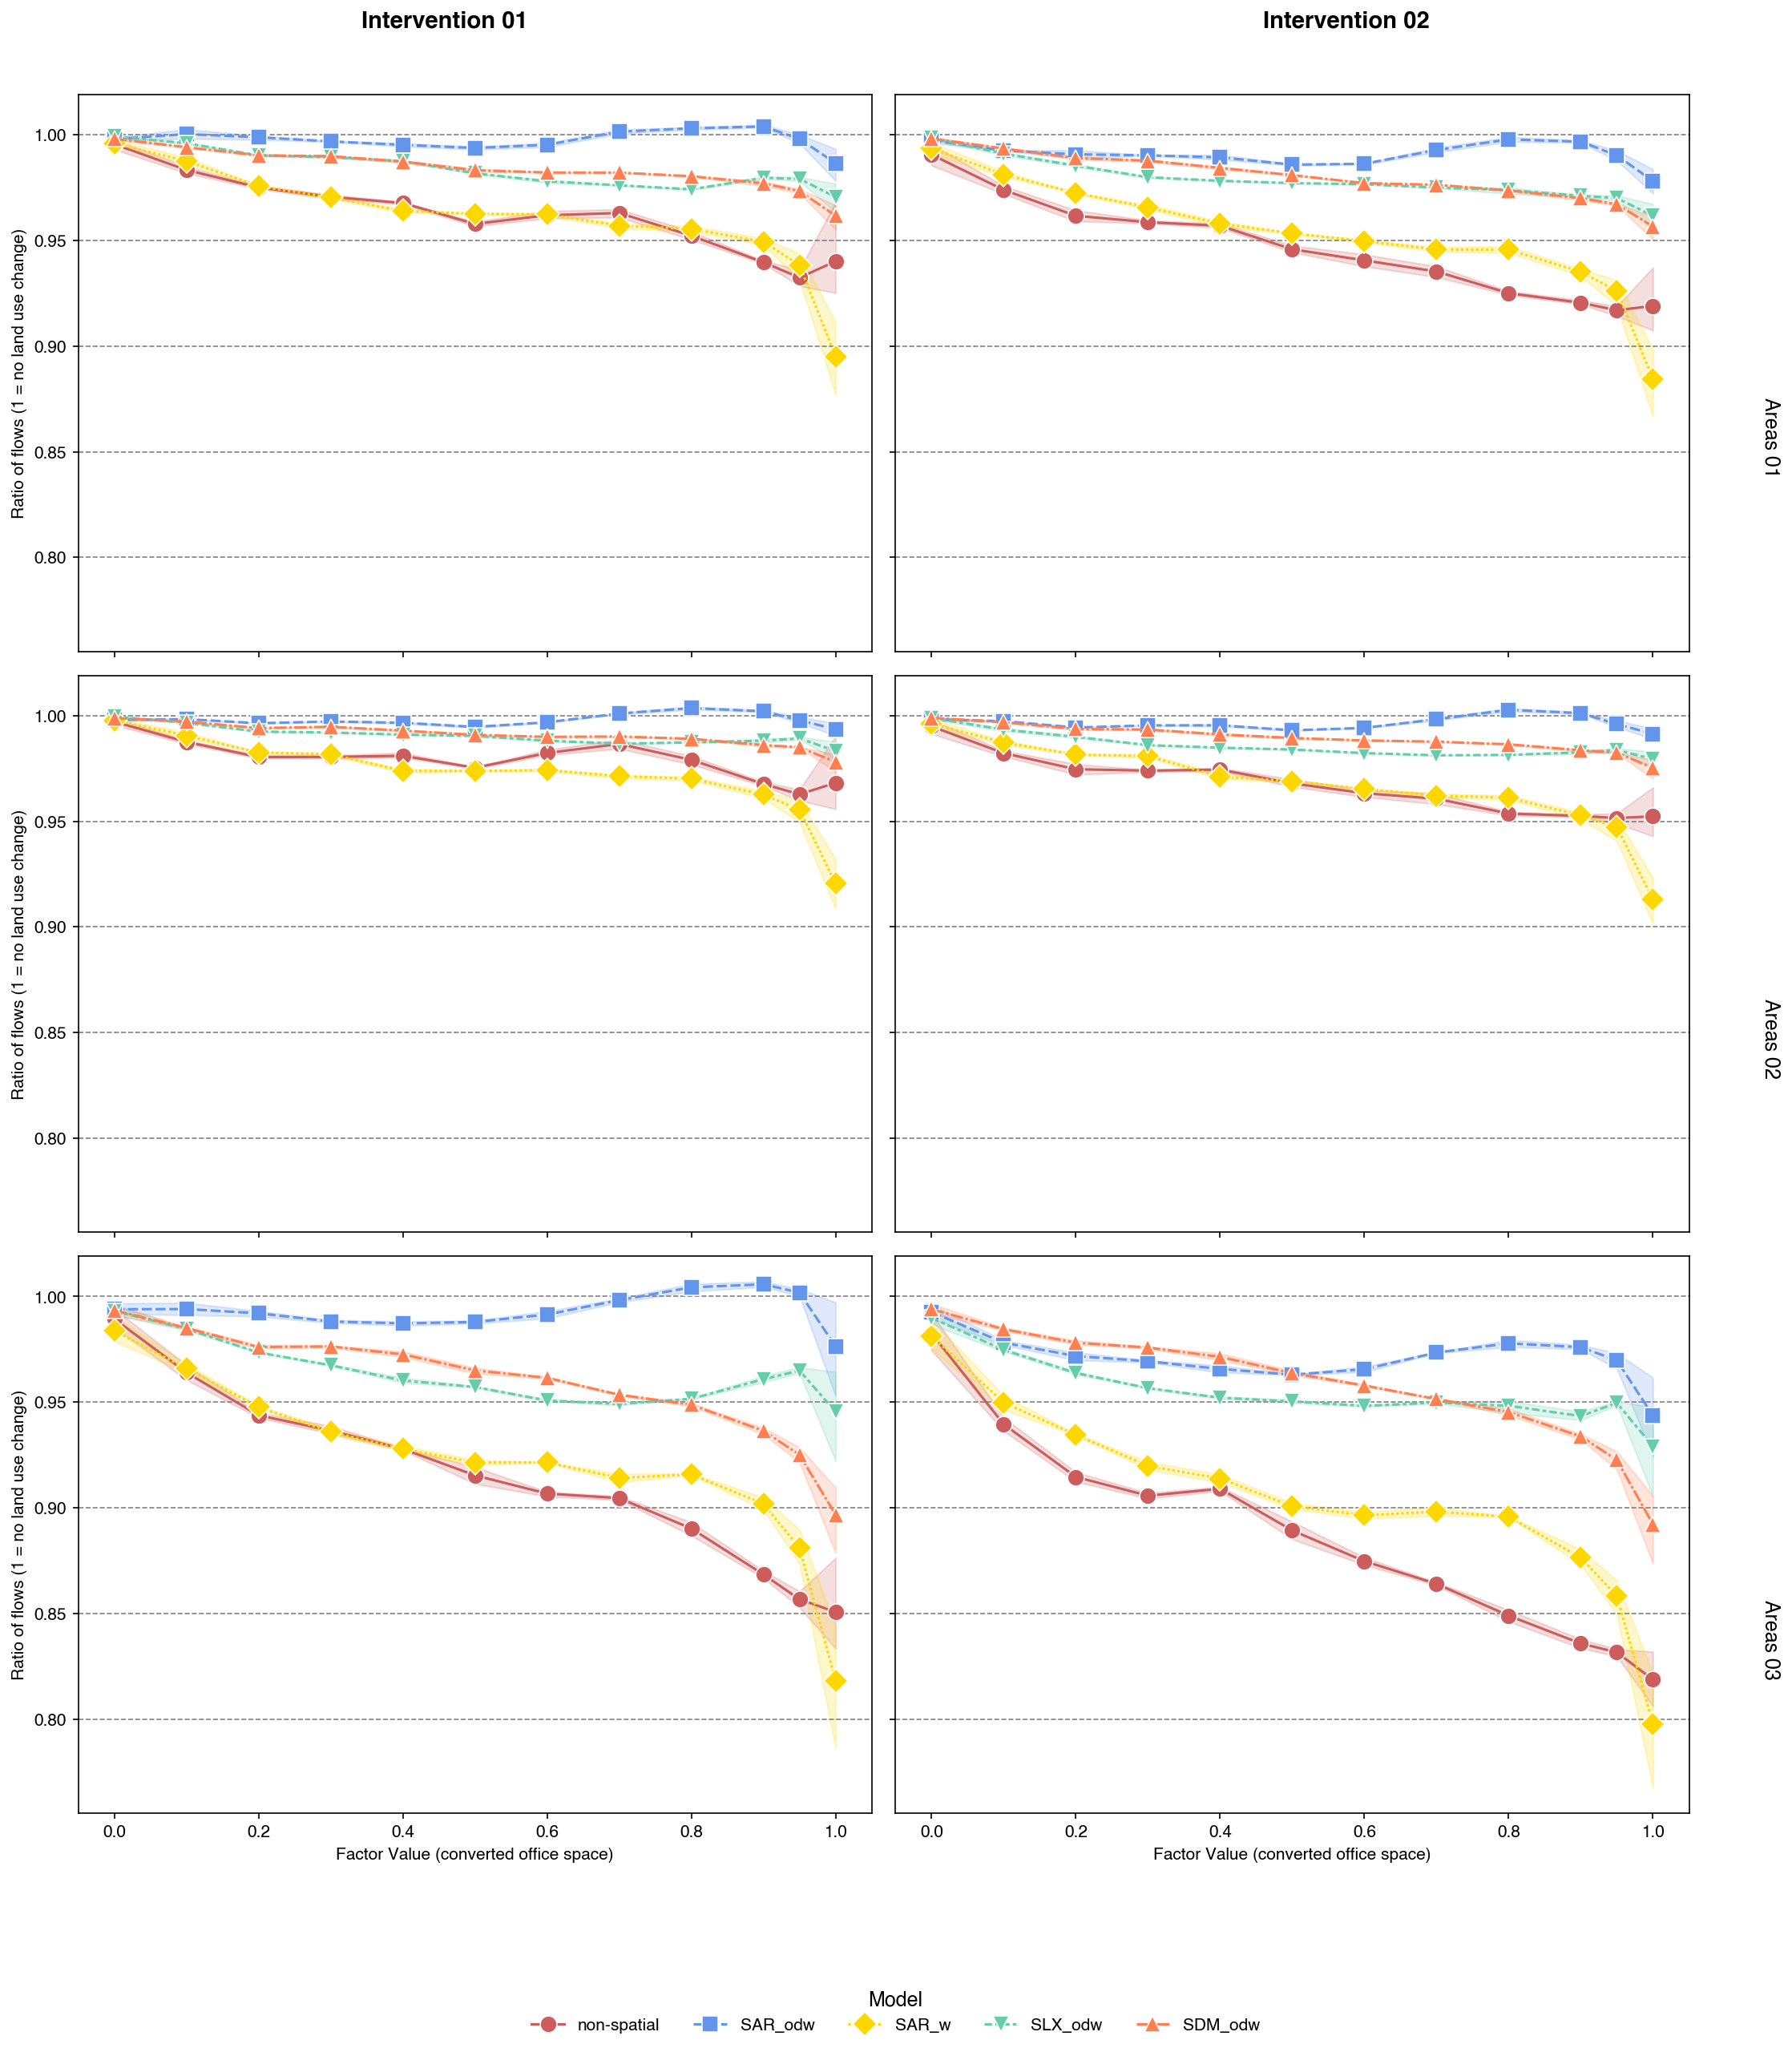

In [88]:
plot_ablation_from_intervention_4x2(data_flows_list)